In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import statsmodels.api as sm

LA celda de abajo es solo para la primera vez que me tuve que bajar los datos de yahoo

In [102]:
# russel2000_components = pd.read_excel('../data/russell_2000.xlsx', sheet_name='Characteristics')

# start_date = '2020-10-23'
# end_date = '2023-12-31'  

# russel2000_prices = yf.download(' '.join(russel2000_components['Ticker'].values), start=start_date, end=end_date)['Adj Close'] 

# russel2000_prices = russel2000_prices.dropna(axis=1)

In [91]:
russel2000_prices=pd.read_csv('../data/russel2000_prices.csv', index_col=0, parse_dates=True)

In [93]:
russel2000_prices_index = pd.read_csv('../data/russel2000_prices_index.csv', index_col=0, parse_dates=True)

In [94]:
ret_russel_2000 = np.log(russel2000_prices).diff().dropna()
ret_russel_2000_index = np.log(russel2000_prices_index).diff().dropna()

In [95]:
matriz_cov = ret_russel_2000.cov().to_numpy()
retornos_esperados = ret_russel_2000.mean().to_numpy() 
num_act = len(ret_russel_2000.columns)

Calculo la cartera de mínimo riesgo

In [80]:
#Variables de decisión
pesos = cp.Variable(num_act)

#Restricciones
constraints = [pesos >= 0,  # No shorting
               cp.sum(pesos) == 1, # Fully invested
               ]

#Función Objetivo
riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
objective = cp.Minimize(riesgo) # Minimizar la varianza

ret = retornos_esperados.T @ pesos # Retorno esperado de la cartera

#Problema y resuelvo
prob = cp.Problem(objective, constraints)
resultado = prob.solve()

#Guardamos los valores de la rentabilidad y riesgo de la cartera de mínimo riesgo
min_riesgo = np.array([riesgo.value, ret.value])

Defino los valores de riesgos usados para calcular la frontera eficiente.

Empieza en el riesgo de la cartera de mínimo riesgo

Acaba en el riesgo del activo con mayor riesgo

In [85]:
riesgos_lst = np.linspace(min_riesgo[0], np.diag(matriz_cov).max(), num=500)

Calculo la cartera de mayor rentabilidad para cada uno de los riesgos anteriores.

Utilizo la librería joblib para hacerlo en paralelo

In [86]:
def optimizar_cartera(risk, num_act, retornos_esperados, matriz_cov):
    # Variables de decisión
    pesos = cp.Variable(num_act)

    # Función objetivo
    rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

    # Restricciones
    riesgo = cp.quad_form(pesos, matriz_cov)
    constraints = [pesos >= 0, cp.sum(pesos) == 1, riesgo <= risk]

    # Resolver problema
    prob = cp.Problem(rentabilidad, constraints)
    resultado = prob.solve(solver=cp.GUROBI)

    return rentabilidad.value, pesos.value



# Paralelización con joblib
resultados = Parallel(n_jobs=-1)(delayed(optimizar_cartera)(risk, num_act, retornos_esperados, matriz_cov) for risk in tqdm(riesgos_lst, desc="Optimizando Carteras"))

# Separar los resultados en listas de retornos y pesos
retornos_lst, pesos_lst = zip(*resultados)

Optimizando Carteras:   0%|          | 0/500 [00:00<?, ?it/s]

Genero y guardo un dataframe con los pesos de las carteras eficientes

In [99]:
russel2000_frontera_pesos = pd.DataFrame(pesos_lst, columns=ret_russel_2000.columns)
russel2000_frontera_pesos.to_csv('../data/russel2000_frontera_pesos.csv')

Genero y guardo un dataframe con los riesgos y retornos de las carteras eficientes

In [101]:
russel2000_frontera = pd.DataFrame({'Riesgo': riesgos_lst, 'Retorno': retornos_lst})
russel2000_frontera.to_csv('../data/russel2000_frontera.csv')

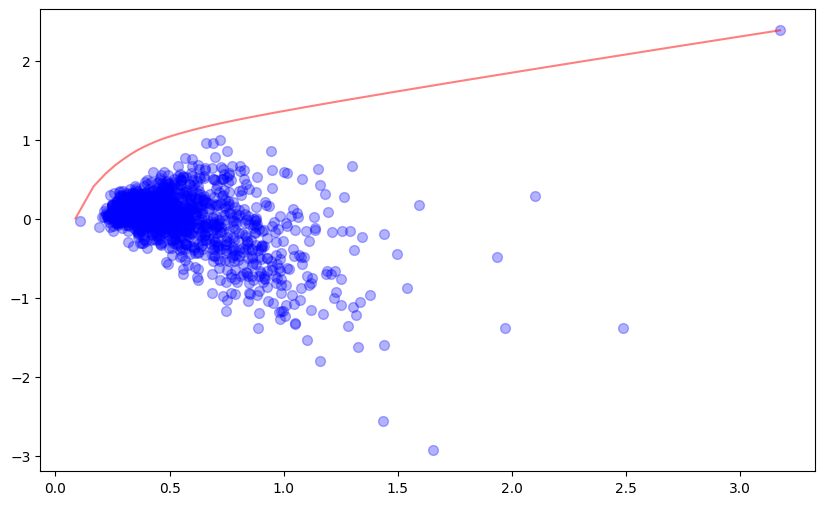

In [87]:
plt.figure(figsize=(10, 6))

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)*252),252* retornos_esperados, color='blue', s=50, alpha=0.3)

plt.plot(np.sqrt(252*riesgos_lst), 252*np.array(retornos_lst), '-', color='red', label='Frontera Eficiente', alpha=0.5)

